In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.tree import DecisionTreeRegressor
plt.rcParams["figure.figsize"] = (20,6)

### Criando as funções

In [15]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [21]:
def apl_model (df_st,n_lags):

    print('Janela Analisada: ', n_lags,'dias\n')

    X = get_lags(df_st, n_lags)
    y = df_st.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'splitter': ['best', 'random'],
             'max_depth': range(1,50)
             }

    dtr = DecisionTreeRegressor()
    dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'criterion': [res.best_params_['criterion']],
             'splitter': [res.best_params_['splitter']],
             'max_depth': [res.best_params_['max_depth']]}
    
    dtr = DecisionTreeRegressor()
    dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)
    print( res.best_score_, res.best_params_)

    r2 = r2_score(dtr_GS.predict(X_test),y_test)
    mse = mean_squared_error(dtr_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(dtr_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(dtr_GS.predict(X_test),y_test)

    print('SVR model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)


    #plot previsão com teste
    fig, ax = plt.subplots()
    ax.plot(dtr_GS.predict(X_test).flatten(), label='pred')
    ax.plot(y_test.reset_index(drop=True), label='true')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show()

   #plot de total com previsão
    previsao = pd.DataFrame(dtr_GS.predict(X_test).flatten(), index = X_test.index)
    concat = pd.concat([y_train, previsao],axis=1)

    concat.plot(linewidth=2, figsize=(20,7), color=['y','b'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Real x Previsto',size=15)
    plt.show();

    fig, ax = plt.subplots()
    ax.plot(df_st, label='Real', color = 'y')
    ax.plot(previsao, label='Previsões', linewidth=2, color='b')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();

    
    return r2, mse, rmse, mae, mape

In [17]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30, 45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse, mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse, mae, mape]
        results.append(result)

    return results

### Lendo dataset

In [18]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_10768\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicando o Modelo

Janela Analisada:  7 dias

########################################
Melhor Score:  0.27933171833664955
Melhores Parametros:  {'criterion': 'squared_error', 'max_depth': 3, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.15382665928419875 {'criterion': 'squared_error', 'max_depth': 3, 'splitter': 'random'}
SVR model Results
r2 -4.144108758879464
mse 1818984.7204431884
rmse 1348.6974161920784
mae 638.1226160700908
mape 0.6895626891677974


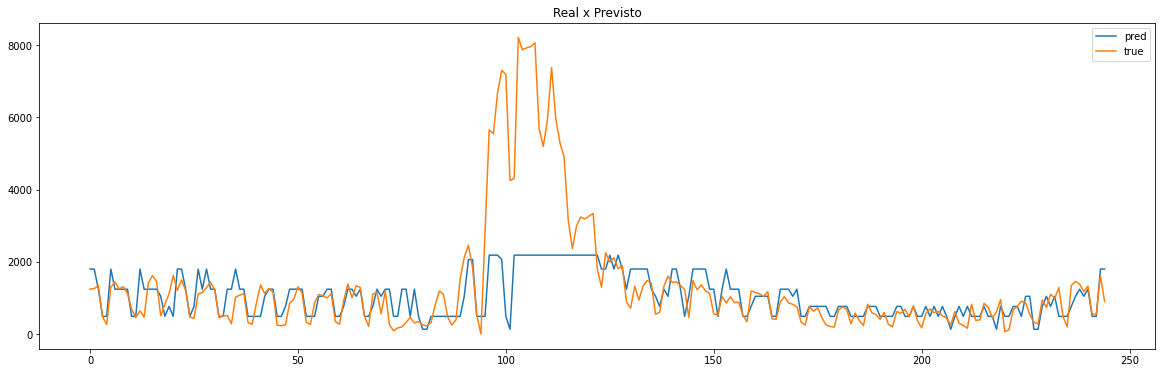

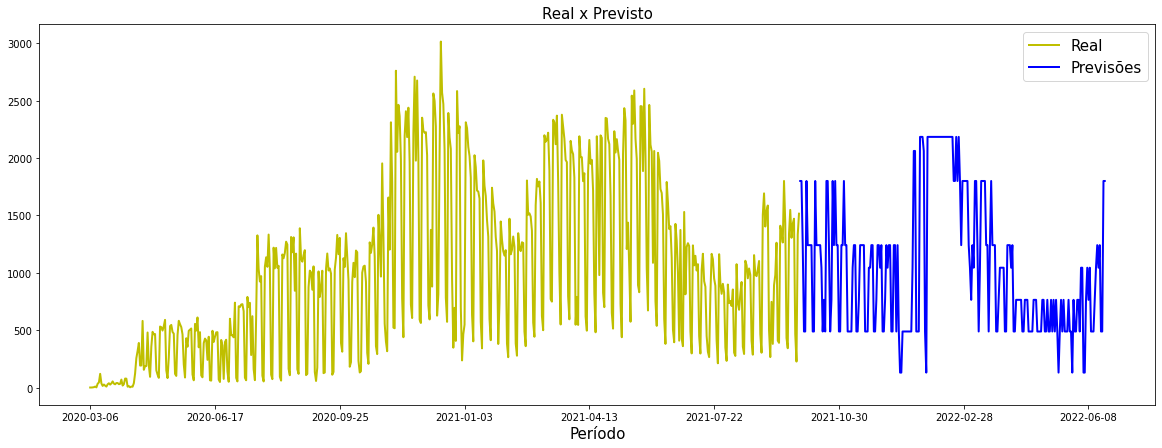

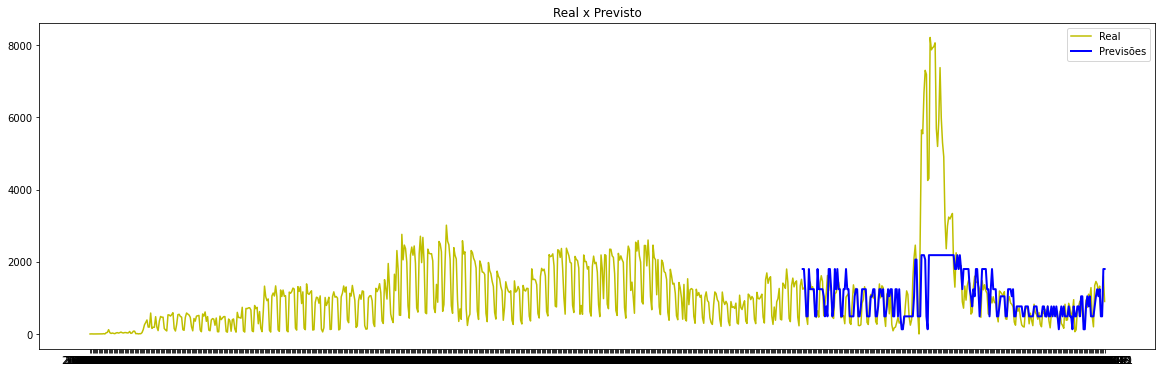

Janela Analisada:  15 dias

########################################
Melhor Score:  0.24288487984727453
Melhores Parametros:  {'criterion': 'squared_error', 'max_depth': 5, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.2521301159825026 {'criterion': 'squared_error', 'max_depth': 5, 'splitter': 'random'}
SVR model Results
r2 -3.4943229602558823
mse 1789726.3377988264
rmse 1337.806539750358
mae 609.3405641774001
mape 0.6837669215261855


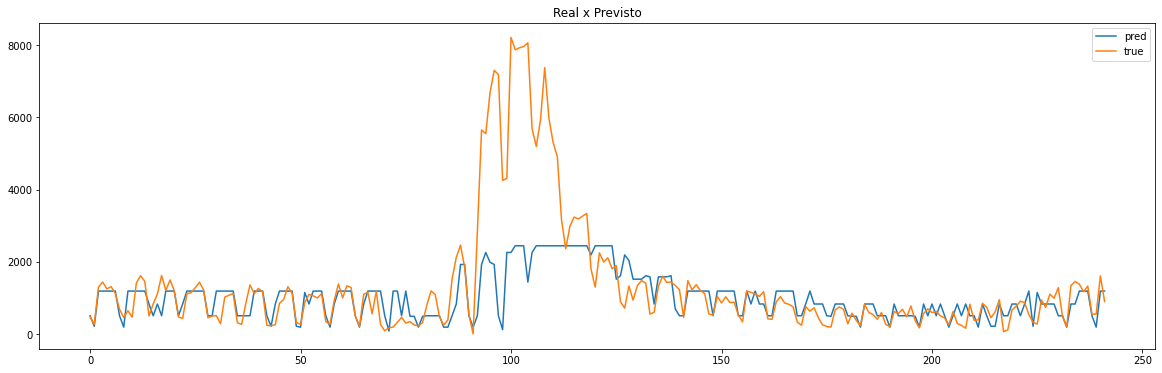

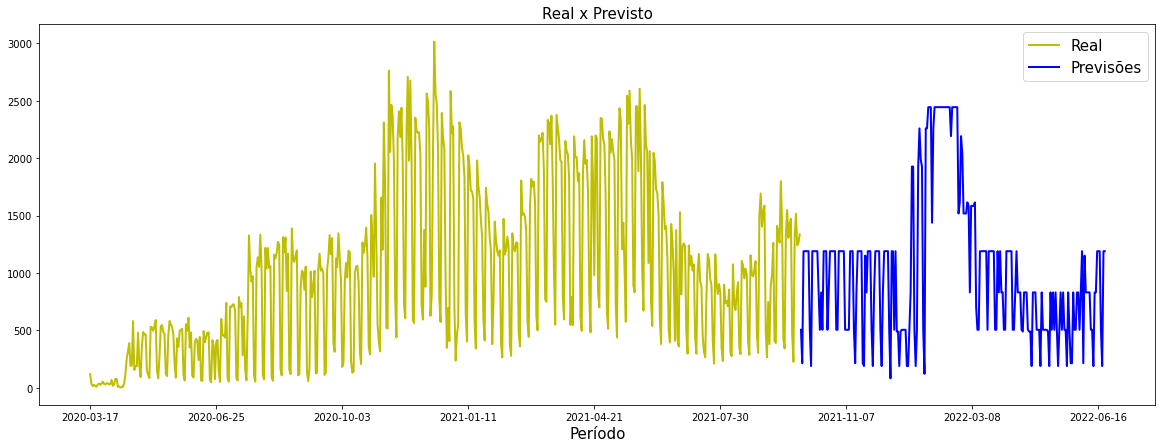

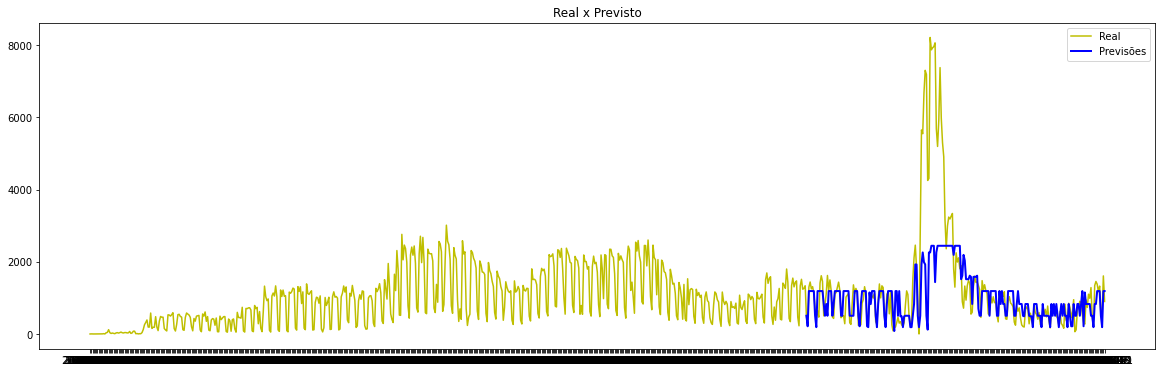

Janela Analisada:  30 dias

########################################
Melhor Score:  0.27379700362966847
Melhores Parametros:  {'criterion': 'poisson', 'max_depth': 2, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.023450868920103507 {'criterion': 'poisson', 'max_depth': 2, 'splitter': 'random'}
SVR model Results
r2 -7.894092266445732
mse 2280097.8219912555
rmse 1509.9992788048792
mae 780.8815324453714
mape 0.7396918063221861


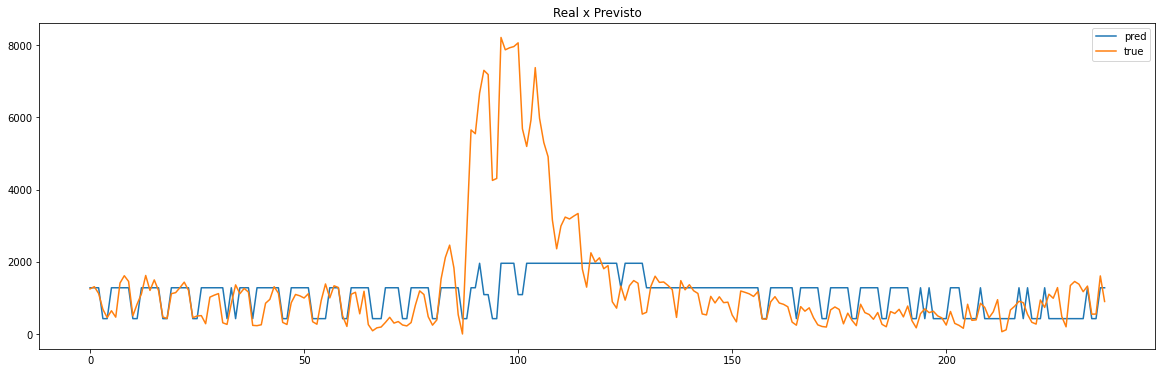

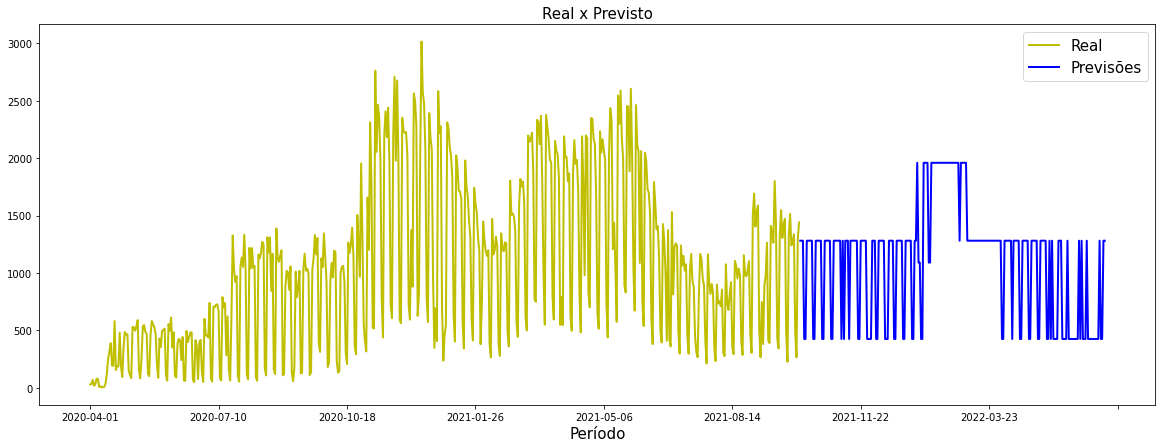

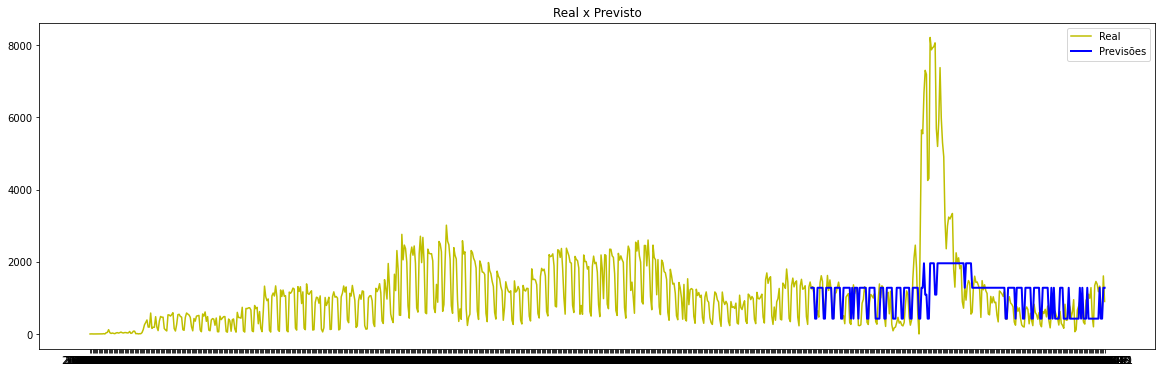

Janela Analisada:  45 dias

########################################
Melhor Score:  0.28411035088911757
Melhores Parametros:  {'criterion': 'friedman_mse', 'max_depth': 3, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.09095336185489664 {'criterion': 'friedman_mse', 'max_depth': 3, 'splitter': 'random'}
SVR model Results
r2 -6.339601715584214
mse 2227476.473855834
rmse 1492.4732740842744
mae 722.8385470829857
mape 0.7791060812195121


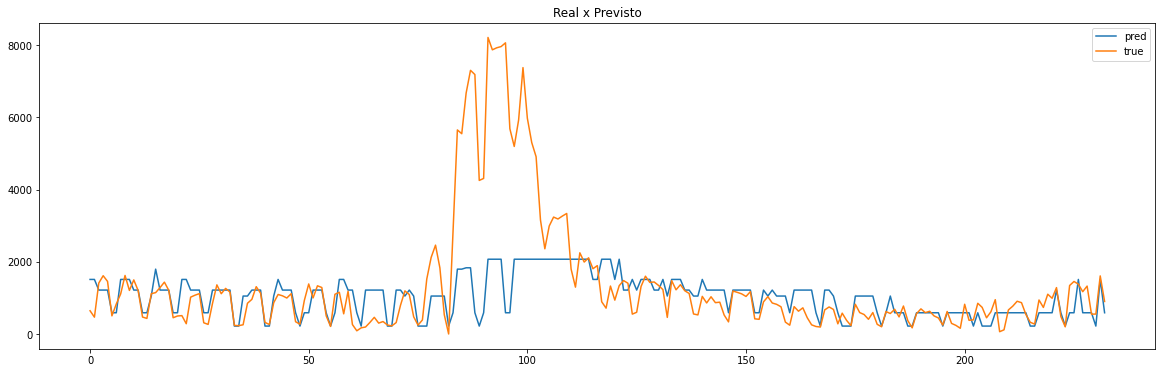

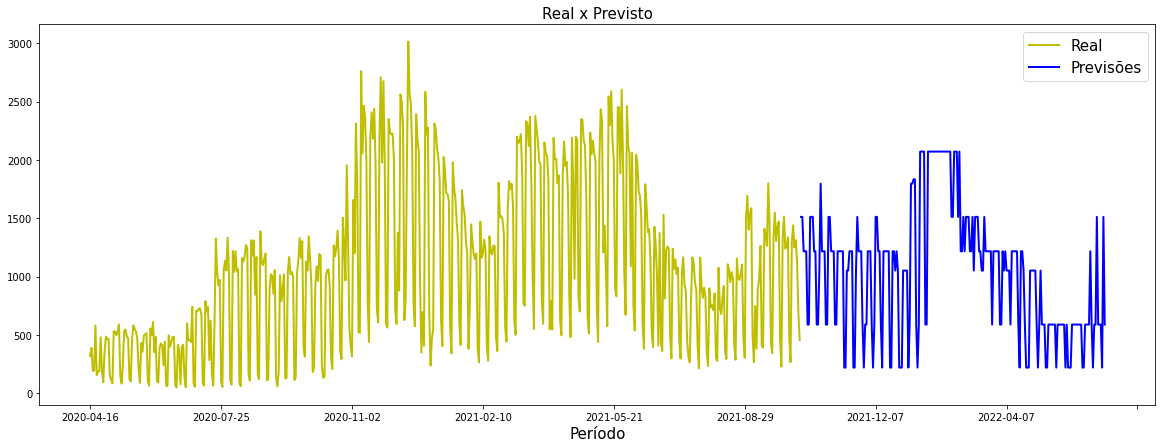

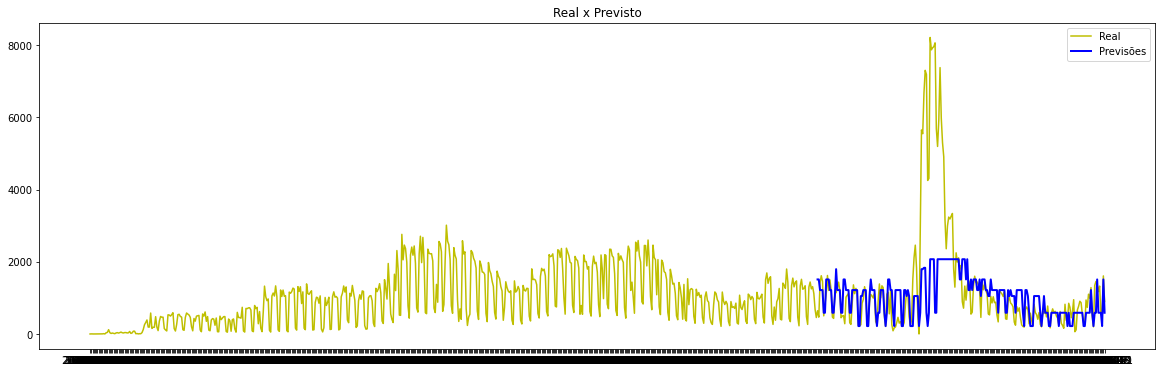

Janela Analisada:  60 dias

########################################
Melhor Score:  0.3865754716240154
Melhores Parametros:  {'criterion': 'friedman_mse', 'max_depth': 3, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.3580330577336472 {'criterion': 'friedman_mse', 'max_depth': 3, 'splitter': 'random'}
SVR model Results
r2 -5.659371111841482
mse 2240295.8680145955
rmse 1496.761794012192
mae 798.4599707019279
mape 0.6713766155702914


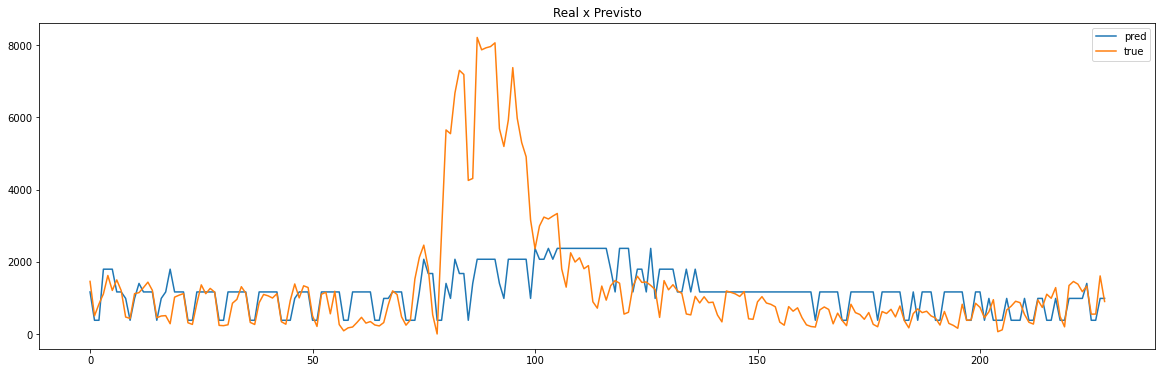

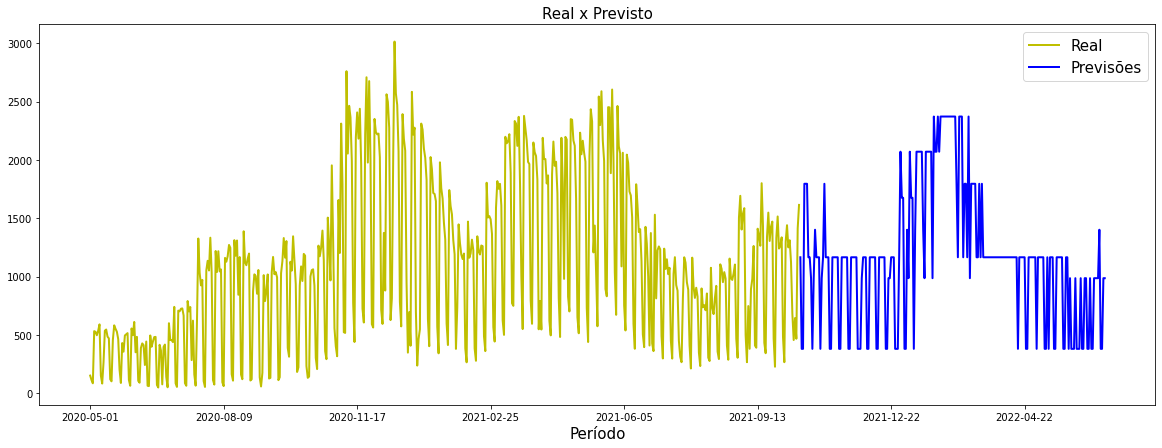

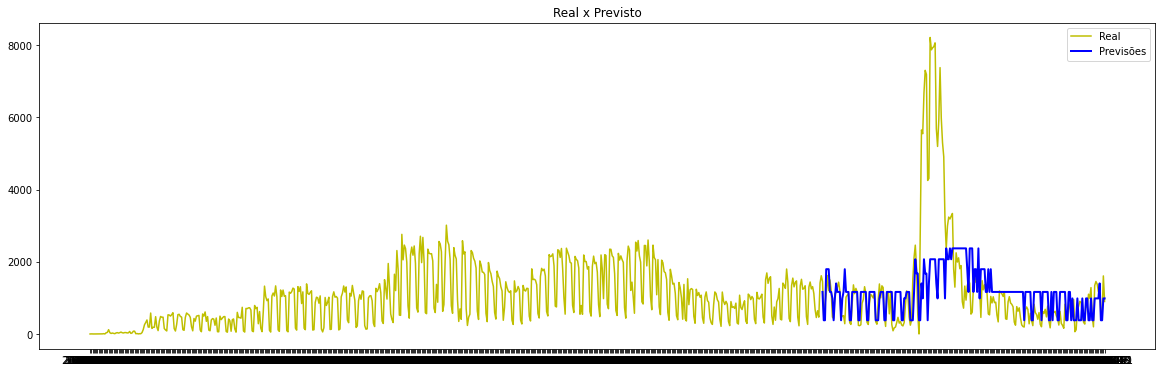

In [22]:
results = apl_for_lags (df_st)

### Resultados

In [23]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results.sort_values(by='R2' , ascending = False)

,R2,MSE,RMSE,MAE,MAPE
15 dias,-3.494323,1.789726e+06,1337.806540,609.340564,0.683767
7 dias,-4.144109,1.818985e+06,1348.697416,638.122616,0.689563
60 dias,-5.659371,2.240296e+06,1496.761794,798.459971,0.671377
45 dias,-6.339602,2.227476e+06,1492.473274,722.838547,0.779106
30 dias,-7.894092,2.280098e+06,1509.999279,780.881532,0.739692
